In [1]:
import pandas as pd

# Load the SQL output (availability results)
batch_times = pd.read_csv("batch_times.csv")

print(batch_times.head())


         date product   batch operator  planned_time_minutes  \
0  2024-08-29  OR-600  422111      Mac                   135   
1  2024-08-29  LE-600  422112      Mac                   100   
2  2024-08-29  LE-600  422113      Mac                   110   
3  2024-08-29  LE-600  422114      Mac                   100   
4  2024-08-29  LE-600  422115  Charlie                    84   

   total_downtime_minutes  run_time  availability  
0                      75        60         0.444  
1                      40        60         0.600  
2                      50        60         0.545  
3                      40        60         0.600  
4                      24        60         0.714  


In [2]:
# Merge batch_times with products and counts

# Load product specs (pipe-delimited)
products = pd.read_csv("products.csv", sep="|")
products.columns = products.columns.str.strip().str.lower()

# Load simulated counts
counts = pd.read_csv("counts_simulated.csv")
counts.columns = counts.columns.str.strip().str.lower()

# Merge batch_times + products + counts
df = (batch_times
      .merge(products[["product","size"]], left_on="product", right_on="product", how="left")
      .merge(counts, on="batch", how="left")) #basically a left join of batch_times with products and then with counts

print(df.head())


         date product   batch operator  planned_time_minutes  \
0  2024-08-29  OR-600  422111      Mac                   135   
1  2024-08-29  LE-600  422112      Mac                   100   
2  2024-08-29  LE-600  422113      Mac                   110   
3  2024-08-29  LE-600  422114      Mac                   100   
4  2024-08-29  LE-600  422115  Charlie                    84   

   total_downtime_minutes  run_time  availability    size  total_units  \
0                      75        60         0.444  600 ml        15140   
1                      40        60         0.600  600 ml        16758   
2                      50        60         0.545  600 ml        16351   
3                      40        60         0.600  600 ml        15926   
4                      24        60         0.714  600 ml        14981   

   reject_units  
0           187  
1           161  
2           154  
3           180  
4           129  


In [3]:
import numpy as np

# Assign ideal production rates (assumptions)
IDEAL_RATE_BY_SIZE = {"600 ml": 300, "2 L": 120}
DEFAULT_RATE = 250

# Map ideal rates
df["ideal_rate_per_min"] = df["size"].map(IDEAL_RATE_BY_SIZE).fillna(DEFAULT_RATE)

# Ideal Cycle Time (sec per unit)
df["ideal_cycle_time_sec"] = 60 / df["ideal_rate_per_min"]

# Convert run_time to seconds
df["run_time_sec"] = df["run_time"] * 60

# Calculate True Performance
df["performance"] = np.where(
    (df["run_time_sec"] > 0) & (df["total_units"] > 0),
    (df["ideal_cycle_time_sec"] * df["total_units"]) / df["run_time_sec"],
    np.nan
).clip(0,1.0).round(3)   # cap at 1.0 and round

# Preview results
print(df[["date","product","batch","run_time","size","total_units","ideal_rate_per_min","performance"]].head())


         date product   batch  run_time    size  total_units  \
0  2024-08-29  OR-600  422111        60  600 ml        15140   
1  2024-08-29  LE-600  422112        60  600 ml        16758   
2  2024-08-29  LE-600  422113        60  600 ml        16351   
3  2024-08-29  LE-600  422114        60  600 ml        15926   
4  2024-08-29  LE-600  422115        60  600 ml        14981   

   ideal_rate_per_min  performance  
0                 300        0.841  
1                 300        0.931  
2                 300        0.908  
3                 300        0.885  
4                 300        0.832  


In [4]:
# STEP 4 — Calculate Quality and OEE 

# 1. Calculate Good Units
df["good_units"] = df["total_units"] - df["reject_units"]

# 2. Quality = Good Units / Total Units
df["quality"] = np.where(
    df["total_units"] > 0,
    df["good_units"] / df["total_units"],
    np.nan
).round(3)

# 3. OEE = A × P × Q
df["oee"] = (df["availability"] * df["performance"] * df["quality"]).round(3)

# 4. Preview results
print(df[["date","product","batch","operator","availability","performance","quality","oee"]].head())

# Save to CSV for reporting
df.to_csv("oee_results.csv", index=False)


         date product   batch operator  availability  performance  quality  \
0  2024-08-29  OR-600  422111      Mac         0.444        0.841    0.988   
1  2024-08-29  LE-600  422112      Mac         0.600        0.931    0.990   
2  2024-08-29  LE-600  422113      Mac         0.545        0.908    0.991   
3  2024-08-29  LE-600  422114      Mac         0.600        0.885    0.989   
4  2024-08-29  LE-600  422115  Charlie         0.714        0.832    0.991   

     oee  
0  0.369  
1  0.553  
2  0.490  
3  0.525  
4  0.589  


In [5]:
# Save final OEE results
df.to_csv("oee_results.csv", index=False)

print("Saved as oee_results.csv")


Saved as oee_results.csv


In [6]:
import pandas as pd
# Load the final dataset
oee_results = pd.read_csv("oee_results.csv")

C:\Users\iampr\AppData\Local\Temp\ipykernel_25408\1610691806.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="product", y="oee", data=oee_results, ci=None)


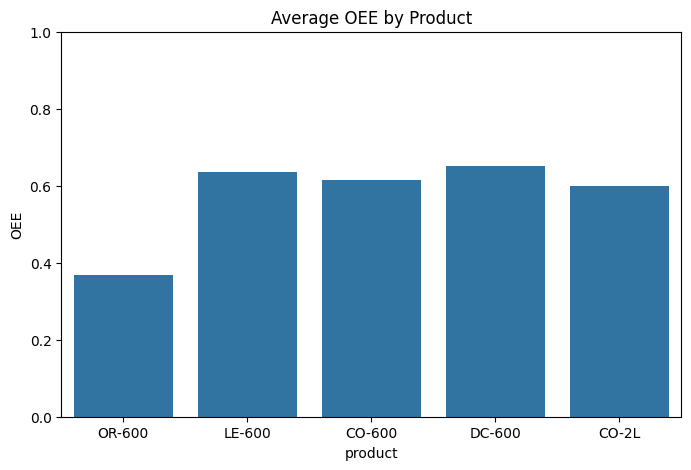

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(x="product", y="oee", data=oee_results, ci=None)
plt.title("Average OEE by Product")
plt.ylabel("OEE")
plt.ylim(0,1)
plt.savefig("avg_oee_by_product.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\iampr\AppData\Local\Temp\ipykernel_25408\2968851242.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="operator", y="oee", data=oee_results, ci=None)


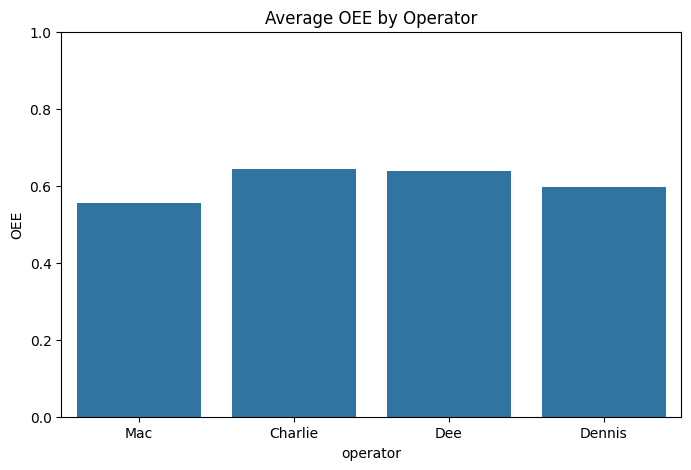

In [8]:
plt.figure(figsize=(8,5))
sns.barplot(x="operator", y="oee", data=oee_results, ci=None)
plt.title("Average OEE by Operator")
plt.ylabel("OEE")
plt.ylim(0,1)   # force axis scale between 0 and 1
plt.savefig("avg_oee_by_operator.png", dpi=300, bbox_inches="tight")
plt.show()
